In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab.data_table import DataTable
DataTable.max_columns = 150

In [ ]:
import pandas as pd

train_set_url = "/content/drive/MyDrive/dataset/KDDTrain_processed.csv"
test_set_url = "/content/drive/MyDrive/dataset/KDDTest_processed.csv"
train_set_url_20 = "/content/drive/MyDrive/dataset/KDDTrain_20%_processed.csv"
test_set_url_20 = "/content/drive/MyDrive/dataset/KDDTest_for20%_processed.csv"

# Load NSL_KDD train dataset preprocessed
df_train_processed = pd.read_csv(train_set_url_20)
# Load NSL_KDD test dataset preprocessed
df_test_processed = pd.read_csv(test_set_url_20)

print(f'TRAIN SET: {df_train_processed.shape}')
print(f'TEST SET: {df_test_processed.shape}')

TRAIN SET: (25192, 118)
TEST SET: (22544, 118)


In [ ]:
# Prepare the feature matrix and target variable for training and test data
X_train = df_train_processed.drop(columns=['attack_class'])
y_train = df_train_processed['attack_class']
X_test = df_test_processed.drop(columns=['attack_class'])
y_test = df_test_processed['attack_class']

# BALANCING DATA

In [ ]:
def create_and_save_balanced_dataset(X_resampled, y_resampled, filename):
    """
    Create a balanced dataset from resampled features and labels,
    remove duplicates, and save it to a CSV file. Returns the balanced dataset.

    Parameters:
    X_resampled (DataFrame): Resampled feature set.
    y_resampled (Series): Resampled labels corresponding to the features.
    filename (str): Name of the file to save the balanced dataset.

    Returns:
    DataFrame: The balanced dataset.
    """
    # Create a new DataFrame from the resampled features
    df_balanced = X_resampled.copy()

    # Add the resampled labels as a new column
    df_balanced['attack_class'] = y_resampled

    # Remove any duplicate rows
    df_balanced = df_balanced.drop_duplicates()

    # Save the balanced dataset to a CSV file
    df_balanced.to_csv(filename, index=False)

    print(f"Balanced dataset saved to {filename}")

    return df_balanced

In [ ]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0, sampling_strategy='auto')
X_res, y_res = smote_enn.fit_resample(X_train, y_train)

df_balanced = create_and_save_balanced_dataset(X_res, y_res, "KDDTrain_balanced.csv")

Balanced dataset saved to KDDTrain_balanced.csv


In [ ]:
print(f'TRAIN SET: {df_balanced.shape}')
print(f'TEST SET: {df_test_processed.shape}')

TRAIN SET: (67006, 118)
TEST SET: (22544, 118)


## Showing Balanced

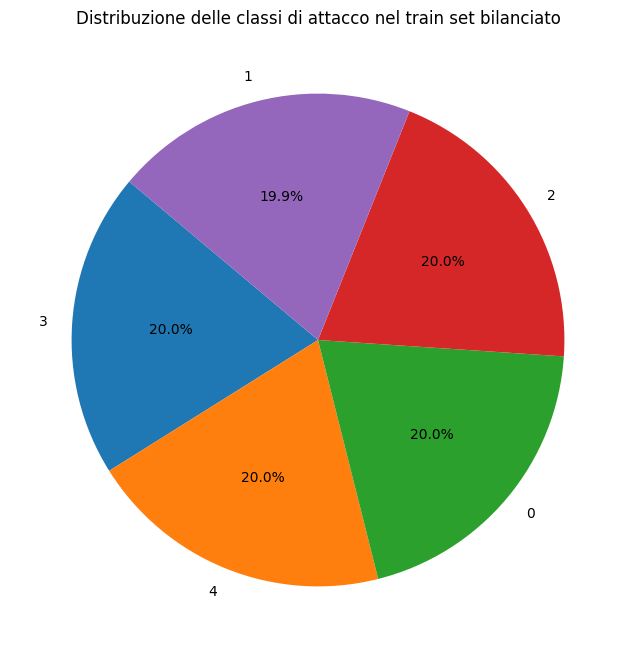

In [ ]:
import Utils

Utils.plot_pie_chart_distribution(
    df=df_balanced,
    column='attack_class',
    title='Distribuzione delle classi di attacco nel train set bilanciato'
)

In [ ]:
df_balanced.shape

(67006, 118)

# TRAINING WITH BALANCED


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def save_feature_importances(rf_classifier, X_train, filename):
    """
    Extract and save feature importances from a Random Forest classifier.

    Parameters:
    rf_classifier (RandomForestClassifier): Trained Random Forest classifier.
    X_train (DataFrame): Training feature matrix used for the classifier.
    filename (str): Name of the file to save the feature importances.

    Returns:
    DataFrame: DataFrame containing feature importances.
    """
    feature_importances = rf_classifier.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    features_df.to_csv(filename, index=True)
    return features_df

def calculate_metrics(y_true, y_pred):
    """
    Calculate and return various evaluation metrics.

    Parameters:
    y_true (Series): True labels.
    y_pred (Series): Predicted labels.

    Returns:
    dict: A dictionary containing various evaluation metrics.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

    return metrics

def print_evaluation_metrics(evaluation_metrics):
    for metric, value in evaluation_metrics.items():
        if metric == 'confusion_matrix':
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value}")

In [ ]:
df_balanced = pd.read_csv("/content/drive/MyDrive/dataset/KDDTrain_20%_balanced.csv")

In [ ]:
X_train_balanced = df_balanced.drop(columns=['attack_class'])
y_train_balanced = df_balanced['attack_class']

In [ ]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)
print(X_test.shape)
print(y_test.shape)

(67006, 117)
(67006,)
(22544, 117)
(22544,)


In [ ]:
# Initialize and fit the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_balanced, y_train_balanced)

# Making predictions
y_pred = rf_classifier.predict(X_test)

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred)
print_evaluation_metrics(evaluation_metrics)

accuracy: 0.751818665720369
precision: 0.8140026295274095
recall: 0.751818665720369
f1_score: 0.7144464619049016
confusion_matrix:
[[5754 1645   59    0    0]
 [  66 9455  187    1    2]
 [ 170  725 1526    0    0]
 [   0 2540    6  206    2]
 [   0  173   14    5    8]]


In [ ]:
# Save feature importances to CSV
feature_importances_df = save_feature_importances(rf_classifier, X_train_balanced, 'features_scores_RF_balanced.csv')

# Display the feature importances
print(feature_importances_df)

               Feature  Importance
1            src_bytes    0.077226
28  dst_host_srv_count    0.061917
2            dst_bytes    0.057621
9      num_compromised    0.055266
8            logged_in    0.049762
..                 ...         ...
98       service_tim_i    0.000000
87       service_red_i    0.000000
85     service_printer    0.000000
16       is_host_login    0.000000
3                 land    0.000000

[117 rows x 2 columns]


### RF with first N features

In [ ]:
# Number of top features selected
N = 60
# Select the top N important features for training and test sets
important_features_rf = feature_importances_df.head(N)['Feature'].values

# Train a new Random Forest Classifier on the top N features
rf_important_classifier = RandomForestClassifier(random_state=42)

# Fit the new classifier on the training data with only the top N important features
rf_important_classifier.fit(X_train_balanced[important_features_rf], y_train_balanced)

# Make predictions with the new classifier
y_pred_important_rf = rf_important_classifier.predict(X_test[important_features_rf])

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred_important_rf)
print_evaluation_metrics(evaluation_metrics)

accuracy: 0.7485361958836054
precision: 0.8125440527017761
recall: 0.7485361958836054
f1_score: 0.7123046385900159
confusion_matrix:
[[5713 1665   80    0    0]
 [  67 9456  186    1    1]
 [ 181  779 1461    0    0]
 [   0 2508    5  238    3]
 [   0  179   12    2    7]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_important_rf))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85      7458
           1       0.65      0.97      0.78      9711
           2       0.84      0.60      0.70      2421
           3       0.99      0.09      0.16      2754
           4       0.64      0.04      0.07       200

    accuracy                           0.75     22544
   macro avg       0.81      0.49      0.51     22544
weighted avg       0.81      0.75      0.71     22544



## Dimensionality Reduction with Variance Threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # Example threshold

selector.fit(X_train_balanced)

X_train_reduced = selector.transform(X_train_balanced)
X_test_reduced = selector.transform(X_test)

print("Original feature count:", X_train_balanced.shape[1])
print("Reduced feature count train:", X_train_reduced.shape[1])
print("Reduced feature count test:", X_test_reduced.shape[1])

Original feature count: 117
Reduced feature count train: 53
Reduced feature count test: 53


In [ ]:
# Initialize and fit the Random Forest Classifier
rf_classifier_red = RandomForestClassifier(random_state=42)
rf_classifier_red.fit(X_train_reduced, y_train_balanced)

# Making predictions
y_pred_red = rf_classifier_red.predict(X_test_reduced)

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred_red)
print_evaluation_metrics(evaluation_metrics)

accuracy: 0.7464513839602555
precision: 0.8129454791595304
recall: 0.7464513839602555
f1_score: 0.707226057270565
confusion_matrix:
[[5717 1703   38    0    0]
 [  67 9449  193    0    2]
 [ 169  763 1489    0    0]
 [   0 2577    6  169    2]
 [   0  183   12    1    4]]


In [ ]:
print(classification_report(y_test, y_pred_red))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85      7458
           1       0.64      0.97      0.77      9711
           2       0.86      0.62      0.72      2421
           3       0.99      0.06      0.12      2754
           4       0.50      0.02      0.04       200

    accuracy                           0.75     22544
   macro avg       0.79      0.49      0.50     22544
weighted avg       0.81      0.75      0.71     22544



# SVM


In [ ]:
# With important Feature
from sklearn.svm import SVC

# Creating and training the SVM model
svm_model = SVC(kernel='linear', gamma='auto')    # Using RBF kernel; you can choose linear, poly, rbf, sigmoid, etc.
svm_model.fit(X_train_balanced[important_features_rf], y_train_balanced)

# Predicting the Test set results
y_pred = svm_model.predict(X_test[important_features_rf])

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred)
print_evaluation_metrics(evaluation_metrics)

accuracy: 0.7874378992193045
precision: 0.8088785146243763
recall: 0.7874378992193045
f1_score: 0.7705025508763009
confusion_matrix:
[[6229 1200   25    4    0]
 [ 500 8908  250   42   11]
 [ 314  316 1790    1    0]
 [   2 1916   16  814    6]
 [   3  175    0   11   11]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      7458
           1       1.00      1.00      1.00      9711
           2       0.80      0.79      0.79      2421
           3       0.64      0.45      0.53      2754
           4       0.41      0.21      0.28       200

    accuracy                           0.88     22544
   macro avg       0.73      0.68      0.69     22544
weighted avg       0.87      0.88      0.87     22544



In [ ]:
# With Reduced Feature
from sklearn.svm import SVC

# Creating and training the SVM model
svm_model = SVC(kernel='linear', gamma='auto')
svm_model.fit(X_train_reduced, y_train_balanced)

# Predicting the Test set results
y_pred = svm_model.predict(X_test_reduced)

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred)
print_evaluation_metrics(evaluation_metrics)

accuracy: 0.8787704045422285
precision: 0.8694770777485469
recall: 0.8787704045422285
f1_score: 0.8701636876029514
confusion_matrix:
[[6970    0   58  430    0]
 [   0 9711    0    0    0]
 [ 300    0 1904  217    0]
 [1219    0  291 1189   55]
 [   6    0  121   36   37]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      7458
           1       1.00      1.00      1.00      9711
           2       0.80      0.79      0.79      2421
           3       0.64      0.43      0.51      2754
           4       0.40      0.18      0.25       200

    accuracy                           0.88     22544
   macro avg       0.73      0.67      0.69     22544
weighted avg       0.87      0.88      0.87     22544

